# Week 4: NLP Disaster Tweets Kaggle Mini-Project

This challenge is about building a machine learning model that predicts which Tweets are about real disasters and which ones aren’t, where our dataset is composed of 10,000 tweets that were hand classified.
To approach this problem, it will be performed a basic exploratory analysis of the training data, to observe general characteristics, such as size, structure, and proportions, then a brief preprocessing of the data using NLP techniques, and finally the proposal of a model of RNN.

In [1]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import gensim
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn


In [2]:
training_data_path = 'D:/PythonCourse/DisasterTweets/data/train.csv'
train_data = pd.read_csv(training_data_path) # Read data from csv file
train_data.head() # View data head to get familiar with the columns

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


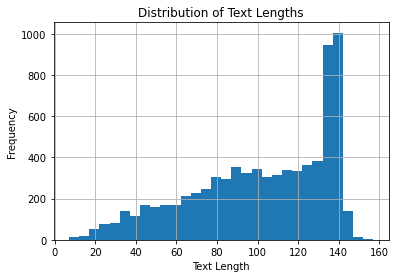

In [3]:
train_data['text_length'] = train_data['text'].apply(len)
train_data['text_length'].hist(bins=30)
plt.title('Distribution of Text Lengths')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.show()


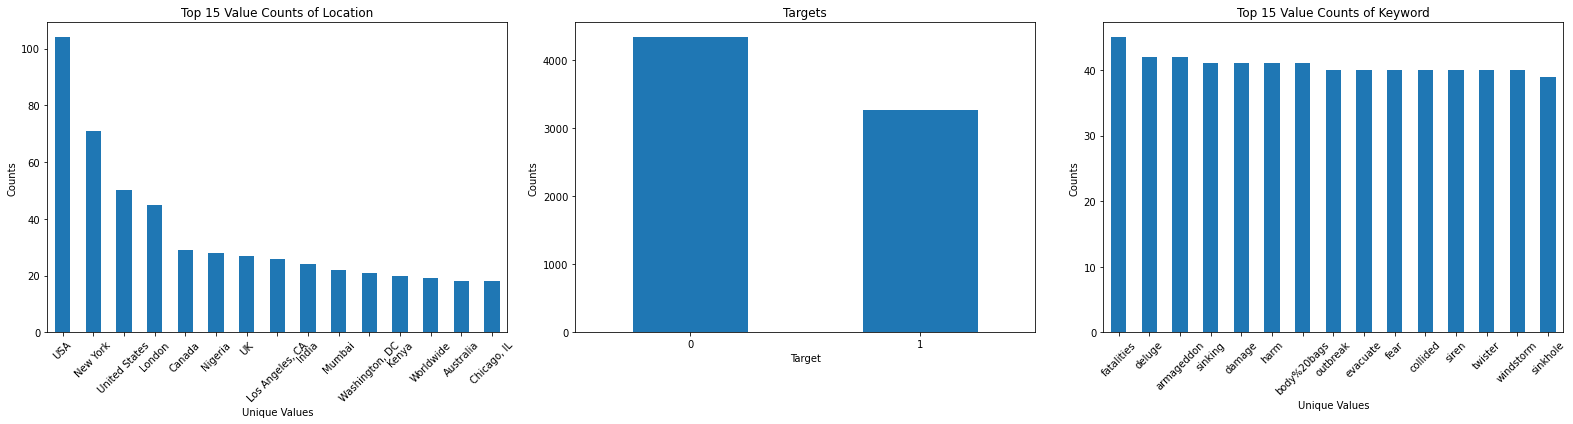

In [4]:

# Create a figure with 1 row and 3 columns (for 3 plots side by side)
fig, axes = plt.subplots(1, 3, figsize=(22, 6)) 

# First plot (location count)
location_count = train_data['location'].value_counts().head(15)
location_count.plot(kind='bar', ax=axes[0])  # Specify which subplot to plot in
axes[0].set_title('Top 15 Value Counts of Location')
axes[0].set_xlabel('Unique Values')
axes[0].set_ylabel('Counts')
axes[0].tick_params(axis='x', rotation=45)

# Second plot (target count)
target_count = train_data['target'].value_counts()
target_count.plot(kind='bar', ax=axes[1])
axes[1].set_title('Targets')
axes[1].set_xlabel('Target')
axes[1].set_ylabel('Counts')
axes[1].tick_params(axis='x', rotation=0)

# Third plot (keyword count)
kw_count = train_data['keyword'].value_counts().head(15)
kw_count.plot(kind='bar', ax=axes[2])
axes[2].set_title('Top 15 Value Counts of Keyword')
axes[2].set_xlabel('Unique Values')
axes[2].set_ylabel('Counts')
axes[2].tick_params(axis='x', rotation=45)

# Adjust layout to avoid overlap
plt.tight_layout()

# Show the plots
plt.show()


To convert the string of text to a format compatible with the structure of Neural Networks, we can use some techniques that encode meaning of words to a vectorial representation useful for this NLP task.
The first one we'll explore is Word2Vec. The goal of Word2Vec is to represent words as vectors (lists of numbers), where words that have similar meanings or are used in similar contexts end up having similar vectors. For example, "king" and "queen" will have vectors that are close to each other, while "king" and "apple" will be far apart because they have very different meanings.

In [40]:
from transformers import BertTokenizer, BertModel
import torch

# Load pretrained BERT model and tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased')

# Tokenize the text and get input_ids and attention masks
def tokenize_tweets(tweets, max_len=128):
    return tokenizer(tweets, padding='max_length', truncation=True, max_length=max_len, return_tensors='pt')

# Tokenize the tweets
tokenized_tweets = tokenize_tweets(train_data['text'].tolist())
input_ids = tokenized_tweets['input_ids']
attention_masks = tokenized_tweets['attention_mask']


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

C:\ProgramData\Anaconda3\lib\site-packages\huggingface_hub\file_download.py:147: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\axguz\.cache\huggingface\hub\models--bert-base-uncased. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [41]:
class BERT_RNN_Classifier(nn.Module):
    def __init__(self, bert_model, rnn_type='LSTM', hidden_dim=128, output_dim=1):
        super(BERT_RNN_Classifier, self).__init__()
        
        self.bert = bert_model
        self.hidden_dim = hidden_dim
        
        # Freeze the BERT parameters (optional, fine-tuning would otherwise happen)
        for param in self.bert.parameters():
            param.requires_grad = False

        # Define RNN (LSTM or GRU)
        if rnn_type == 'LSTM':
            self.rnn = nn.LSTM(input_size=768, hidden_size=hidden_dim, batch_first=True)
        elif rnn_type == 'GRU':
            self.rnn = nn.GRU(input_size=768, hidden_size=hidden_dim, batch_first=True)
        
        # Fully connected layer for classification
        self.fc = nn.Linear(hidden_dim, output_dim)
        
        # Sigmoid for binary classification
        self.sigmoid = nn.Sigmoid()

    def forward(self, input_ids, attention_mask):
        # Get BERT embeddings
        with torch.no_grad():  # Optional: don't update BERT weights
            outputs = self.bert(input_ids, attention_mask=attention_mask)
        
        # BERT embeddings (batch_size, sequence_length, 768)
        embeddings = outputs.last_hidden_state

        # Feed BERT embeddings into RNN
        rnn_output, _ = self.rnn(embeddings)
        
        # Use the final hidden state for classification
        final_output = rnn_output[:, -1, :]
        
        # Fully connected layer
        output = self.fc(final_output)
        
        # Sigmoid activation for binary classification
        return self.sigmoid(output)


In [42]:
from torch.utils.data import DataLoader, TensorDataset

# Convert inputs and labels to PyTorch tensors
labels = torch.tensor(train_data['target'].values)

# Create a dataset and data loader
dataset = TensorDataset(input_ids, attention_masks, labels)
batch_size = 16
train_dataloader = DataLoader(dataset, shuffle=True, batch_size=batch_size)


In [43]:
import torch.optim as optim
import torch.nn as nn

# Instantiate the model
model = BERT_RNN_Classifier(bert_model, rnn_type='LSTM', hidden_dim=128, output_dim=1)

# Define loss and optimizer
criterion = nn.BCELoss()  # Binary Cross Entropy Loss
optimizer = optim.Adam(model.parameters(), lr=2e-5)

# Training loop
epochs = 4
for epoch in range(epochs):
    model.train()
    
    total_loss = 0
    for step, batch in enumerate(train_dataloader):
        batch_input_ids, batch_attention_mask, batch_labels = batch
        
        # Forward pass
        outputs = model(batch_input_ids, attention_mask=batch_attention_mask)
        loss = criterion(outputs.squeeze(), batch_labels.float())
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    avg_loss = total_loss / len(train_dataloader)
    print(f'Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}')


Epoch 1/4, Loss: 0.6480
Epoch 2/4, Loss: 0.5410
Epoch 3/4, Loss: 0.4923
Epoch 4/4, Loss: 0.4789


#### References
Word2Vec https://en.wikipedia.org/wiki/Word2vec#:~:text=Word2vec%20is%20a%20technique%20in,text%20in%20a%20large%20corpus.